# H-DNA Analysis Homo Sapiens

In [56]:
import pandas as pd
import pybedtools
from pybedtools import BedTool
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import gzip
import warnings

warnings.filterwarnings('ignore')
pybedtools.set_tempdir("/storage/home/nmc6088/scratch")

In [57]:
fasta_path = Path("/storage/group/izg5139/default/external/quadrupia_database/g4/nonBDNA/primates/fasta")
telo_path = Path("/storage/group/izg5139/default/external/satellites/primates/telomeres")
gff_path = Path("/storage/group/izg5139/default/external/satellites/primates/gff")
centro_path = Path("/storage/group/izg5139/default/external/satellites/primates/centromeres")

mirror_path = Path("/storage/group/izg5139/default/external/quadrupia_database/g4/nonBDNA/extraction/nonbdna_primates/processed/MR")
inverted_path = Path("/storage/group/izg5139/default/external/quadrupia_database/g4/nonBDNA/extraction/nonbdna_primates/processed/IR")
compartment = "gene"

extract_species = lambda file: file.name.split('.')[0]
extract_species_ = lambda file: extract_species(file) if file.name.startswith("chm") else extract_species(file) + "_v2"
mirror_paths = {extract_species_(file): file for file in mirror_path.glob("*.csv")}
fasta_paths = {extract_species_(file): file for file in fasta_path.glob("*.fna.gz")}
inverted_paths = {extract_species_(file): file for file in inverted_path.glob("*.csv")}
gff_paths = {file.name.replace("-", "_").split("_")[3].split(".")[0]: file for file in gff_path.glob("*.gff.gz")}
gff_paths = {species + "_v2" if not species.startswith("CHM") else "chm13v2": file for species, file in gff_paths.items()}
centro_paths = {extract_species(file): file for file in centro_path.glob("*.bed") if "bb" not in file.name and "censat" in file.name.lower()}
telo_paths = {extract_species(file): file for file in telo_path.glob("*.bed")}
fasta_paths

{'chm13v2': PosixPath('/storage/group/izg5139/default/external/quadrupia_database/g4/nonBDNA/primates/fasta/chm13v2.0.fna.gz'),
 'mGorGor1_v2': PosixPath('/storage/group/izg5139/default/external/quadrupia_database/g4/nonBDNA/primates/fasta/mGorGor1.pri.cur.20231122.fna.gz'),
 'mPanPan1_v2': PosixPath('/storage/group/izg5139/default/external/quadrupia_database/g4/nonBDNA/primates/fasta/mPanPan1.pri.cur.20231122.fna.gz'),
 'mPanTro3_v2': PosixPath('/storage/group/izg5139/default/external/quadrupia_database/g4/nonBDNA/primates/fasta/mPanTro3.pri.cur.20231122.fna.gz'),
 'mPonAbe1_v2': PosixPath('/storage/group/izg5139/default/external/quadrupia_database/g4/nonBDNA/primates/fasta/mPonAbe1.pri.cur.20231205.fna.gz'),
 'mPonPyg2_v2': PosixPath('/storage/group/izg5139/default/external/quadrupia_database/g4/nonBDNA/primates/fasta/mPonPyg2.pri.cur.20231122.fna.gz'),
 'mSymSyn1_v2': PosixPath('/storage/group/izg5139/default/external/quadrupia_database/g4/nonBDNA/primates/fasta/mSymSyn1.pri.cur.202

In [58]:
def load_mirror(species):
    mirror_df = pd.read_table(mirror_paths[species]).drop(columns=['#assembly_accession'])
    mirror_df.loc[:, "pyrine"] = mirror_df["sequence"].str.count("a|g").div(mirror_df["sequence"].apply(len))
    mirror_df.loc[:, "pyrimidine"] = mirror_df["sequence"].str.count("c|t").div(mirror_df["sequence"].apply(len))
    mirror_df.loc[:, "at_content"] = mirror_df["sequence"].str.count("a|t").div(mirror_df["sequence"].apply(len))
    mirror_df = mirror_df[((mirror_df['pyrine'] >= 0.9) | (mirror_df['pyrimidine'] >= 0.9)) & (mirror_df['at_content'] <= 0.8)]
    mirror_df = mirror_df.query("spacerLength < 8 & armLength > 9")
    return mirror_df

In [59]:
human_chromosomes = {
                1: 'NC_060925.1',
                2: 'NC_060926.1',	
                3: 'NC_060927.1',
                4: 'NC_060928.1',
                5: 'NC_060929.1',
                6: 'NC_060930.1',
                7: 'NC_060931.1',
                8: 'NC_060932.1',
                9: 'NC_060933.1',	
                10: 'NC_060934.1',	
                11: 'NC_060935.1',	
                12: 'NC_060936.1',		
                13: 'NC_060937.1',	
                14: 'NC_060938.1',
                15: 'NC_060939.1',		
                16: 'NC_060940.1',		
                17: 'NC_060941.1',	
                18: 'NC_060942.1',	
                19: 'NC_060943.1',	
                20: 'NC_060944.1',	
                21: 'NC_060945.1',	
                22: 'NC_060946.1',	
                'X': 'NC_060947.1',
                'Y': 'NC_060948.1',
             }

In [60]:
chromosomes = {k: v for v, k in human_chromosomes.items()}
GFF_FIELDS = ["seqID", "source", "compartment", "start", "end", "score", "strand", "phase", "attributes"]

In [61]:
gff_human = pd.read_table(
                        gff_paths['chm13v2'], 
                        comment="#", 
                        header=None,
                        names=["chromosome", "source", "compartment", "start", "end", "score", "strand", "phase", "attributes"],
                    )
valid_compartments = {"region", "gene", "CDS", "exon", "gene"}
gff_human = gff_human[gff_human['compartment'].isin(valid_compartments)]
gff_human.loc[:, "chromosome"] = gff_human["chromosome"].apply(lambda x: f'chr{chromosomes[x]}')
gff_human

,chromosome,source,compartment,start,end,score,strand,phase,attributes
0,chr1,RefSeq,region,1,248387328,.,+,.,ID=NC_060925.1:1..248387328;Dbxref=taxon:9606;...
1,chr1,BestRefSeq,gene,7506,138480,.,-,.,ID=gene-LOC127239154;Dbxref=GeneID:127239154;N...
3,chr1,BestRefSeq,exon,138321,138480,.,-,.,ID=exon-NR_182074.1-1;Parent=rna-NR_182074.1;D...
4,chr1,BestRefSeq,exon,129906,130010,.,-,.,ID=exon-NR_182074.1-2;Parent=rna-NR_182074.1;D...
5,chr1,BestRefSeq,exon,109651,109660,.,-,.,ID=exon-NR_182074.1-3;Parent=rna-NR_182074.1;D...
...,...,...,...,...,...,...,...,...,...
4729902,chrY,Gnomon,CDS,62448758,62448826,.,+,2,ID=cds-XP_047303139.1;Parent=rna-XM_047447183....
4729903,chrY,Gnomon,CDS,62448967,62449100,.,+,2,ID=cds-XP_047303139.1;Parent=rna-XM_047447183....
4729906,chrY,BestRefSeq,exon,62451557,62451910,.,-,.,ID=exon-NR_110561.1-2-1;Parent=rna-NR_110561.1...
4729907,chrY,BestRefSeq,exon,62451063,62451171,.,-,.,ID=exon-NR_110561.1-2-2;Parent=rna-NR_110561.1...


In [62]:
gff_human[gff_human['chromosome'].isna()]

,chromosome,source,compartment,start,end,score,strand,phase,attributes


In [63]:
# mirror_df = mirror_df[mirror_df['sequence'].apply(lambda x: x.count(x[0]) != len(x))]
mirror_df = load_mirror("chm13v2")
mirror_df.head()

,chromosome,sequenceLength,armLength,composition,start,end,sequenceOfArm,sequenceOfSpacer,spacerLength,sequence,arm_a,arm_c,arm_g,arm_t,pyrine,pyrimidine,at_content
9,chr1,29,11,3A/0C/8G/0T,50042,50071,ggagggaggga,ggcagaa,7,ggagggagggaggcagaaagggagggagg,3,0,8,0,0.965517,0.034483,0.310345
10,chr1,27,10,4A/0C/6G/0T,50059,50086,aagggaggga,ggcagaa,7,aagggagggaggcagaaagggagggaa,4,0,6,0,0.962963,0.037037,0.407407
21,chr1,39,19,15A/0C/4G/0T,73390,73429,agaaagaaaaagaaagaaa,g,1,agaaagaaaaagaaagaaagaaagaaagaaaaagaaaga,15,0,4,0,1.000000,0.000000,0.769231
22,chr1,43,21,16A/0C/5G/0T,73420,73463,aaagaaagaaagaaagaaaga,a,1,aaagaaagaaagaaagaaagaaagaaagaaagaaagaaagaaa,16,0,5,0,1.000000,0.000000,0.767442
23,chr1,43,21,16A/0C/5G/0T,73422,73465,agaaagaaagaaagaaagaaa,g,1,agaaagaaagaaagaaagaaagaaagaaagaaagaaagaaaga,16,0,5,0,1.000000,0.000000,0.744186


In [64]:
mirror_df = pd.read_table(mirror_paths["chm13v2"]).drop(columns=['#assembly_accession'])
mirror_df.loc[:, "pyrine"] = mirror_df["sequence"].str.count("a|g").div(mirror_df["sequence"].apply(len))
mirror_df.loc[:, "pyrimidine"] = mirror_df["sequence"].str.count("c|t").div(mirror_df["sequence"].apply(len))
mirror_df.loc[:, "at_content"] = mirror_df["sequence"].str.count("a|t").div(mirror_df["sequence"].apply(len))
mirror_df = mirror_df[((mirror_df['pyrine'] >= 0.9) | (mirror_df['pyrimidine'] >= 0.9)) & (mirror_df['at_content'] <= 0.8)]
mirror_df = mirror_df.query("spacerLength < 8 & armLength > 9")

# mirror_df = mirror_df[mirror_df['sequence'].apply(lambda x: x.count(x[0]) != len(x))]
mirror_df

,chromosome,sequenceLength,armLength,composition,start,end,sequenceOfArm,sequenceOfSpacer,spacerLength,sequence,arm_a,arm_c,arm_g,arm_t,pyrine,pyrimidine,at_content
9,chr1,29,11,3A/0C/8G/0T,50042,50071,ggagggaggga,ggcagaa,7,ggagggagggaggcagaaagggagggagg,3,0,8,0,0.965517,0.034483,0.310345
10,chr1,27,10,4A/0C/6G/0T,50059,50086,aagggaggga,ggcagaa,7,aagggagggaggcagaaagggagggaa,4,0,6,0,0.962963,0.037037,0.407407
21,chr1,39,19,15A/0C/4G/0T,73390,73429,agaaagaaaaagaaagaaa,g,1,agaaagaaaaagaaagaaagaaagaaagaaaaagaaaga,15,0,4,0,1.000000,0.000000,0.769231
22,chr1,43,21,16A/0C/5G/0T,73420,73463,aaagaaagaaagaaagaaaga,a,1,aaagaaagaaagaaagaaagaaagaaagaaagaaagaaagaaa,16,0,5,0,1.000000,0.000000,0.767442
23,chr1,43,21,16A/0C/5G/0T,73422,73465,agaaagaaagaaagaaagaaa,g,1,agaaagaaagaaagaaagaaagaaagaaagaaagaaagaaaga,16,0,5,0,1.000000,0.000000,0.744186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145817,chrY,27,13,0A/6C/0G/7T,62192836,62192863,tctctctctctct,c,1,tctctctctctctctctctctctctct,0,6,0,7,0.000000,1.000000,0.518519
1145818,chrY,27,13,0A/7C/0G/6T,62192837,62192864,ctctctctctctc,t,1,ctctctctctctctctctctctctctc,0,7,0,6,0.000000,1.000000,0.481481
1145829,chrY,22,11,7A/0C/4G/0T,62247108,62247130,aaagaaggaag,NaN,0,aaagaaggaaggaaggaagaaa,7,0,4,0,1.000000,0.000000,0.636364
1145831,chrY,28,14,5A/0C/9G/0T,62255805,62255833,aggaggaggaggag,NaN,0,aggaggaggaggaggaggaggaggagga,5,0,9,0,1.000000,0.000000,0.357143


In [65]:
human_centro = pd.read_table(
                             centro_paths['chm13v2'], 
                             usecols=range(4), 
                             names=["chromosome", "start", "end", "compartment"],
                             skiprows=1, 
                             header=None
                            )

human_centro.loc[:, "compartment"] = human_centro["compartment"].str.split("_", expand=True)[0]

In [66]:
human_all = pd.concat([
                       human_centro, 
                       gff_human
                    ], 
                axis=0)

human_all

,chromosome,start,end,compartment,source,score,strand,phase,attributes
0,chr1,116796047,121405145,ct,NaN,NaN,NaN,NaN,NaN
1,chr1,121405145,121406286,censat,NaN,NaN,NaN,NaN,NaN
2,chr1,121406286,121619169,ct,NaN,NaN,NaN,NaN,NaN
3,chr1,121619169,121625213,hor,NaN,NaN,NaN,NaN,NaN
4,chr1,121625213,121667941,hor,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
4729902,chrY,62448758,62448826,CDS,Gnomon,.,+,2,ID=cds-XP_047303139.1;Parent=rna-XM_047447183....
4729903,chrY,62448967,62449100,CDS,Gnomon,.,+,2,ID=cds-XP_047303139.1;Parent=rna-XM_047447183....
4729906,chrY,62451557,62451910,exon,BestRefSeq,.,-,.,ID=exon-NR_110561.1-2-1;Parent=rna-NR_110561.1...
4729907,chrY,62451063,62451171,exon,BestRefSeq,.,-,.,ID=exon-NR_110561.1-2-2;Parent=rna-NR_110561.1...


In [79]:
human_centro_bed = BedTool.from_dataframe(human_all[["chromosome", "start", "end", "compartment"]])
human_satellites_bed = BedTool.from_dataframe(human_centro[["chromosome", "start", "end", "compartment"]])

hdna_bed = BedTool.from_dataframe(mirror_df[["chromosome", "start", "end"]])
hdna_bed

<BedTool(/storage/home/nmc6088/scratch/pybedtools.d945gvlx.tmp)>

In [80]:
intersection_covering = pd.read_table(
                                      hdna_bed.intersect(human_satellites_bed, wao=True).fn,
                                      header=None,
                                      names=["seqID", "start", "end", "chromo", "mStart", "mEnd", "comp", "overlap"],
                                )
intersection_covering

,seqID,start,end,chromo,mStart,mEnd,comp,overlap
0,chr1,50042,50071,.,-1,-1,.,0
1,chr1,50059,50086,.,-1,-1,.,0
2,chr1,73390,73429,.,-1,-1,.,0
3,chr1,73420,73463,.,-1,-1,.,0
4,chr1,73422,73465,.,-1,-1,.,0
...,...,...,...,...,...,...,...,...
205188,chrY,62192836,62192863,.,-1,-1,.,0
205189,chrY,62192837,62192864,.,-1,-1,.,0
205190,chrY,62247108,62247130,.,-1,-1,.,0
205191,chrY,62255805,62255833,.,-1,-1,.,0


In [81]:
intersection_covering['comp'] = intersection_covering['comp'].replace('.', 'Other')

In [82]:
intersection_covering['comp'].unique()

array(['Other', 'ct', 'hsat3', 'bsat', 'censat', 'mon', 'rDNA', 'dhor',
       'gsat'], dtype=object)

In [83]:
from collections import Counter

In [87]:
rDNA_compartments = human_centro.query("compartment == 'rDNA'")
rDNA_compartments

,chromosome,start,end,compartment
794,chr13,5770548,9348041,rDNA
943,chr14,2099537,2817811,rDNA
1161,chr15,2506442,4707485,rDNA
1807,chr21,3108298,5612715,rDNA
1986,chr22,4793794,5720650,rDNA


In [ ]:
chromosomes_with_rdna = set(rDNA_compartments['chromosome'].unique())
chromosomes_with_rdna

# Where do H-DNA tend to belong (in absolute numbers)?

In [84]:
intersection_covering.loc[:, 'hdna_len'] = intersection_covering['end'] - intersection_covering['start']
covering_inter_df = intersection_covering.groupby(["seqID", "start", "end", "hdna_len"], as_index=False)\
                                         .agg(
                                            compartment_counts=("comp", lambda ds: Counter(ds.tolist())),
                                            compartment=("comp", "first"),
                                            total_overlap=("overlap", "sum"),
                                            total_compartments=("comp", "count"),
                                        )
covering_inter_df

,seqID,start,end,hdna_len,compartment_counts,compartment,total_overlap,total_compartments
0,chr1,50042,50071,29,{'Other': 1},Other,0,1
1,chr1,50059,50086,27,{'Other': 1},Other,0,1
2,chr1,73390,73429,39,{'Other': 1},Other,0,1
3,chr1,73420,73463,43,{'Other': 1},Other,0,1
4,chr1,73422,73465,43,{'Other': 1},Other,0,1
...,...,...,...,...,...,...,...,...
205187,chrY,62192836,62192863,27,{'Other': 1},Other,0,1
205188,chrY,62192837,62192864,27,{'Other': 1},Other,0,1
205189,chrY,62247108,62247130,22,{'Other': 1},Other,0,1
205190,chrY,62255805,62255833,28,{'Other': 1},Other,0,1


<Axes: xlabel='compartment'>

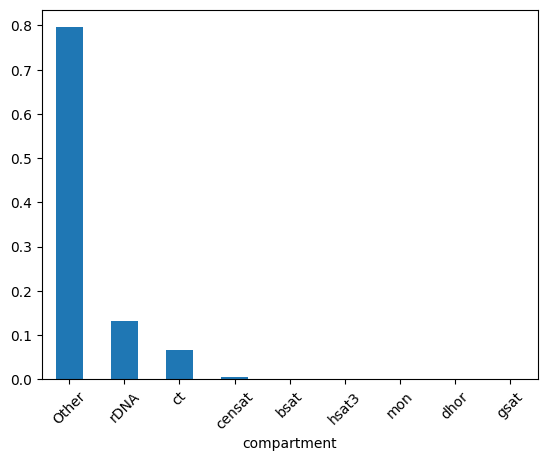

In [93]:
covering_inter_df.compartment.value_counts(normalize=True).plot(kind="bar", rot=45)

# limit to chromosomes that actually have rDNA

<Axes: xlabel='compartment'>

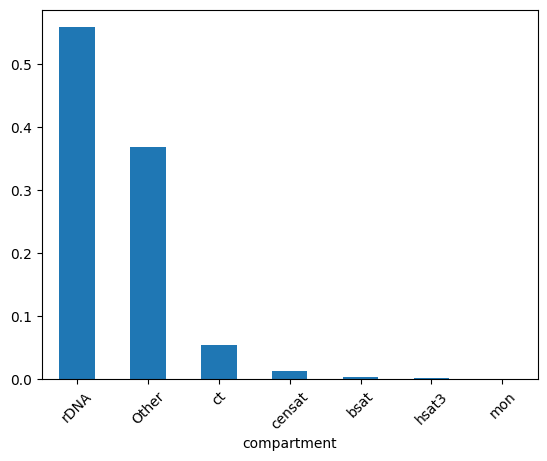

In [94]:
covering_inter_df[covering_inter_df['seqID'].isin(chromosomes_with_rdna)].compartment\
                                                                         .value_counts(normalize=True)\
                                                                         .plot(kind="bar", rot=45)

In [95]:
def find_remaining(x):
    if x['compartment'] == 'Other':
        return x['hdna_len']
        
    return x['hdna_len'] - x['total_overlap']

In [96]:
covering_inter_df.loc[:, "remaining"] = covering_inter_df[["hdna_len", 
                                                           "compartment", 
                                                           "total_overlap"]]\
                                                    .apply(find_remaining, axis=1)

In [38]:
covering_inter_df.query("totalDiffComp > 1")

,seqID,start,end,hdna_len,compartment_counts,compartment,overlaps,total_overlap,total_compartments,totalDiffComp
160000,chr6,57217087,57217110,23,"{'mon': 1, 'ct': 1}","[mon, ct]","[6, 17]",23,2,2


# H-DNA Density per Satellite Compartment

In [97]:
human_centro_bed = BedTool.from_dataframe(human_all[["chromosome", "start", "end", "compartment"]])
hdna_bed = BedTool.from_dataframe(mirror_df[["chromosome", "start", "end"]])

hdna_coverage = pd.read_table(human_centro_bed.coverage(hdna_bed).fn,
                              header=None,
                              names=["seqID", "start", "end", "compartment", "totalHits", "bpCovering", "compLength", "coverage"],
                             )
hdna_coverage['coverage'] = hdna_coverage['coverage'] * 1e6
hdna_coverage

,seqID,start,end,compartment,totalHits,bpCovering,compLength,coverage
0,chr1,116796047,121405145,ct,243,5153,4609098,1118.0
1,chr1,121405145,121406286,censat,0,0,1141,0.0
2,chr1,121406286,121619169,ct,25,449,212883,2109.1
3,chr1,121619169,121625213,hor,0,0,6044,0.0
4,chr1,121625213,121667941,hor,0,0,42728,0.0
...,...,...,...,...,...,...,...,...
3846400,chrY,62448758,62448826,CDS,0,0,68,0.0
3846401,chrY,62448967,62449100,CDS,0,0,133,0.0
3846402,chrY,62451557,62451910,exon,0,0,353,0.0
3846403,chrY,62451063,62451171,exon,0,0,108,0.0


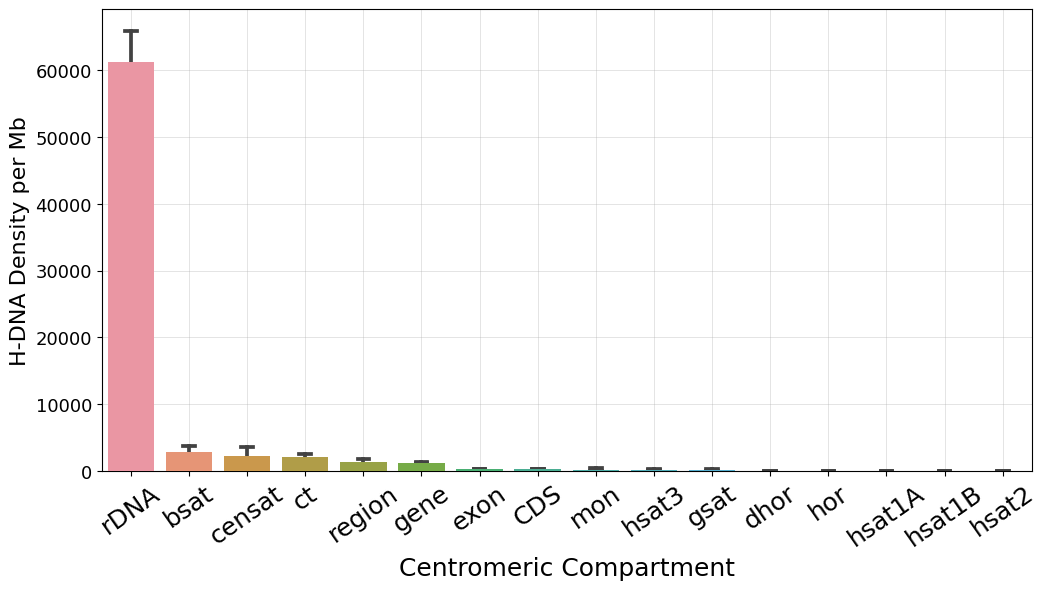

In [98]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.barplot(data=hdna_coverage,
            y="coverage",
            x="compartment",
            zorder=3,
            ax=ax,
            capsize=0.2,
            order=hdna_coverage.groupby("compartment").agg({"coverage": "mean"}).sort_values(by=['coverage'], ascending=False).index,
           )
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.set_xlabel("Centromeric Compartment")
ax.set_ylabel("H-DNA Density per Mb")
ax.yaxis.label.set_size(16)
ax.xaxis.label.set_size(18)
ax.tick_params(axis="x", labelsize=18, rotation=35)
ax.tick_params(axis="y", labelsize=13)

# Limit to rDNA satellites

In [99]:
rDNA = human_centro[human_centro['compartment'] == 'rDNA']
rDNA.drop(columns=['compartment'], inplace=True)
rDNA = rDNA.rename(columns={"start": "rDNA_start", 
                            "end": "rDNA_end"})
rDNA

,chromosome,rDNA_start,rDNA_end
794,chr13,5770548,9348041
943,chr14,2099537,2817811
1161,chr15,2506442,4707485
1807,chr21,3108298,5612715
1986,chr22,4793794,5720650


In [12]:
human_centro_bed = BedTool.from_dataframe(human_centro)

In [ ]:
rDNA = human_centro[human_centro['compartment'] == 'rDNA']
rDNA.columns = ['chromosome', 'rDNA_start', 'rDNA_end', 'd']
rDNA.drop(columns=['d'], inplace=True)
rDNA

In [ ]:
total_bins = 3_500
mirror_rdna = mirror_df.merge(rDNA, on="chromosome", how="inner")
mirror_rdna["start"] = mirror_rdna["start"] - mirror_rdna["rDNA_start"]
mirror_rdna["end"] = mirror_rdna["end"] - mirror_rdna["rDNA_start"]
mirror_rdna["rdna_size"] = mirror_rdna["rDNA_end"] - mirror_rdna["rDNA_start"]
mirror_rdna = mirror_rdna[(mirror_rdna["start"] >= 0) & (mirror_rdna["end"] <= mirror_rdna["rdna_size"])]

mirror_rdna.loc[:, "start_bin"] = 1 + np.floor( total_bins * mirror_rdna["start"] / mirror_rdna["rdna_size"])
mirror_rdna.loc[:, "end_bin"] = 1 + np.floor( total_bins * mirror_rdna["end"] / mirror_rdna["rdna_size"])

mirror_rdna